In [1]:
import corner
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time
from tqdm import tqdm_notebook as tqdm

import data_loader
import model_short as model
import toy_data_loader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True, precision=4)

In [3]:
class hps:
    pass
hps.n_levels = 3 # number of splits
hps.depth = 3 # number of layers in revnet
hps.width = 16 # channels in revnet layers
hps.polyak_epochs = 1
hps.beta1 = .9 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.n_data = 16000 # number of input spectra
hps.batch_size = 50 # number of spectra in a batch
hps.n_batches = int(hps.n_data / hps.batch_size)
hps.n_bins = 2**15

In [4]:
sess = tf.InteractiveSession()

In [5]:
# select real or toy data by uncommenting the appropriate line
# real data must have n_data=8000, n_bins=40000
#input_stream, initialize_input_stream, data_init = data_loader.create_data_loader(
input_stream, initialize_input_stream, data_init = toy_data_loader.create_data_loader(
    sess, hps.batch_size, hps.n_data, hps.n_bins
)

/home/tey/glow/toy_data_loader.py:9: RuntimeWarning: overflow encountered in exp
  return 2 * h * c**2 / wavelength**5 * 1 / (np.exp(h * c / (wavelength * k * T)) - 1)
W0205 16:51:31.780139 139851541747456 deprecation.py:323] From /home/tey/glow/toy_data_loader.py:35: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


(50, 32768, 1)


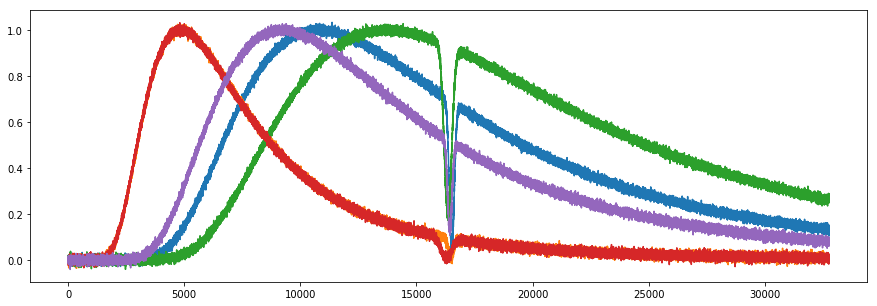

In [6]:
print(data_init.shape)
plt.figure(figsize=(15, 5))
for spectrum in data_init[:5]:
    plt.plot(spectrum)

In [7]:
with tf.device("/device:GPU:0"):
    m = model.model(sess, hps, input_stream, data_init)

W0205 16:51:36.516498 139851541747456 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0205 16:51:36.570628 139851541747456 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



Tensor("input/latent_rep:0", shape=(?, 2048, 4), dtype=float32, device=/device:GPU:0)
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048


W0205 16:51:40.118023 139851541747456 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048


W0205 16:51:42.496132 139851541747456 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:157: The name tf.matrix_inverse is deprecated. Please use tf.linalg.inv instead.

W0205 16:51:42.611898 139851541747456 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:184: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 4096, 4) (1, 1, 4) 4096
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192
actnorm_scale (?, 8192, 4) (1, 1, 4) 8192


In [8]:
%%time
m.train(.001)

CPU times: user 2.62 s, sys: 856 ms, total: 3.47 s
Wall time: 2.58 s


array([120.46], dtype=float32)

In [ ]:
n_processed = 0

hps.epochs = 20
hps.epochs_warmup = 1
hps.print_freq = 10

for epoch in tqdm(range(1, hps.epochs + 1), desc='Epochs'):
    train_results = []
    initialize_input_stream()
    with tqdm(total=hps.n_batches) as pbar:
        for iteration in range(hps.n_batches):
            pbar.set_description('Epoch ' + str(epoch))
            lr = hps.lr * min(1., n_processed / (hps.batch_size * hps.n_batches * hps.epochs_warmup))
            train_results += [m.train(lr)]
            n_processed += hps.batch_size
            pbar.set_postfix(lr=lr, loss=np.mean(train_results))
            pbar.update()

In [8]:
i = np.random.randint(0, hps.batch_size)
spectrum = data_init[i:i+1, :, :]
print(i)

21


In [18]:
latent_rep = m.encode(spectrum)
reconstruction = m.decode(latent_rep)
print(latent_rep.mean(), latent_rep.std())

0.056547668 1.0388029


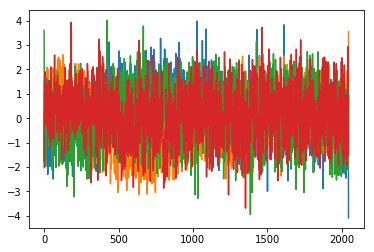

In [19]:
for channel in range(latent_rep.shape[-1]):
    plt.plot(latent_rep[0, :, channel])

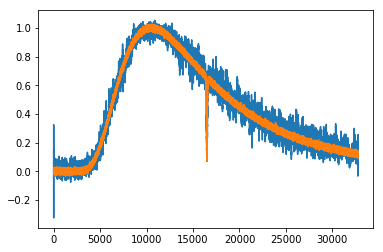

In [20]:
plt.plot(np.squeeze(reconstruction))
plt.plot(np.squeeze(spectrum))

(15564.8, 17203.2)

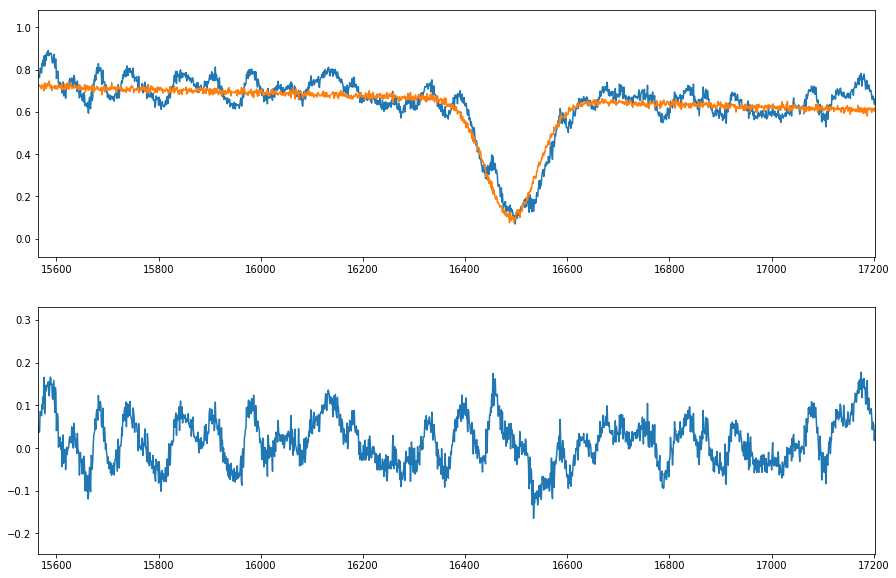

In [21]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(np.clip(reconstruction, 0, 1)))
plt.plot(np.squeeze(spectrum))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.475, hps.n_bins*.525)

plt.subplot(2, 1, 2)
plt.plot(np.squeeze(np.clip(reconstruction, 0, 1)) - np.squeeze(spectrum))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.475, hps.n_bins*.525)

In [55]:
# Make a corner plot with 4 components of the latent representation
latent_reps = np.empty([0, 2500])
initialize_input_stream()
with tqdm(total=hps.n_batches) as pbar:
    for _ in range(hps.n_batches):
        data = sess.run(input_stream)
        latent_rep = m.encode(data)
        latent_reps = np.append(latent_reps, latent_rep[:, :, 0], axis=0) # select all channels of one component
        pbar.set_postfix(mean=latent_reps.mean(), std=latent_reps.std())
        pbar.update()

In [64]:
start_position = 700
components = 8
print(latent_reps.shape)
print(latent_reps[:, start_position:start_position + components].mean(axis=0))
print(latent_reps[:, start_position:start_position + components].std(axis=0))

(8000, 2500)
[-0.488   0.1839 -0.4894 -0.1904 -0.2148  0.5258 -0.653  -0.1355]
[0.5421 0.8834 1.1718 0.7451 0.8864 1.0354 0.9121 0.6323]


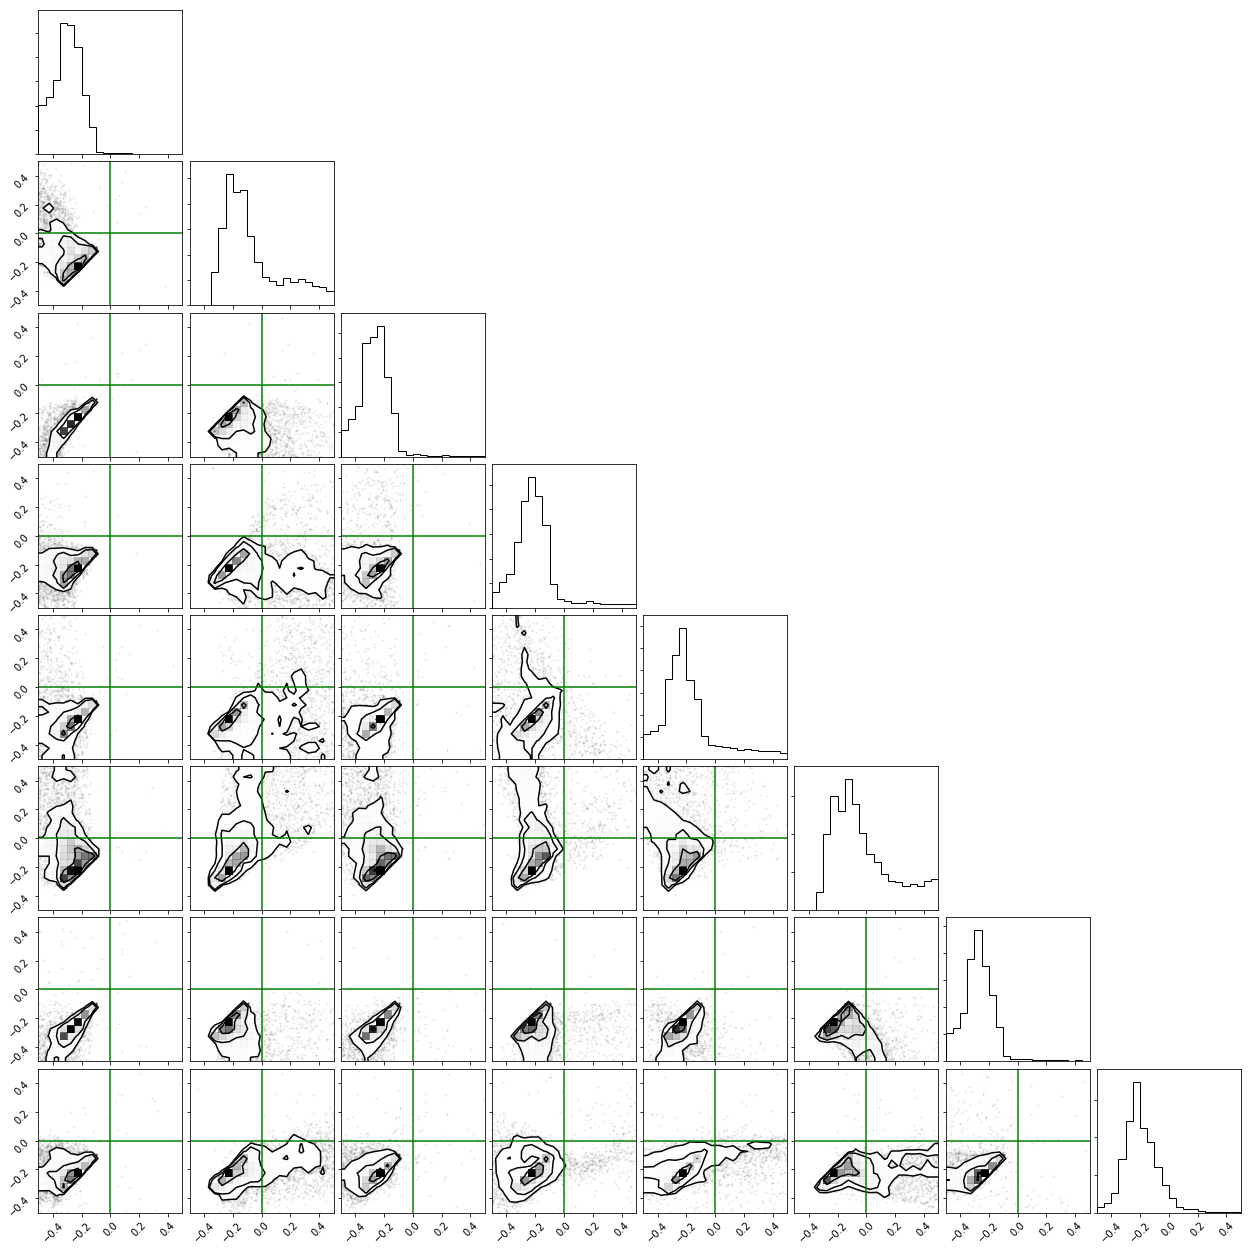

In [65]:
figure = corner.corner(latent_reps[:, start_position:start_position + components], 
                       range=components*[(-.5, .5)])

axes = np.array(figure.axes).reshape((components, components))
for yi in range(components):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(0, color="g")
        ax.axhline(0, color="g")

(array([ 562., 1816., 3633., 1633.,   54.,   34.,   19.]),
 array([-1.5 , -1.  , -0.5 , -0.25,  0.  ,  0.5 ,  1.  ,  1.5 ]),
 <a list of 7 Patch objects>)

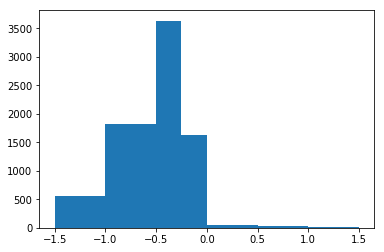

In [66]:
plt.hist(latent_reps[:, 700], bins=[-1.5, -1, -.5, -.25, 0, .5, 1, 1.5])

In [40]:
m.save('test')

'test'

In [13]:
m.restore('test')

W0205 16:52:56.806307 139851541747456 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/saver.py:1272: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
tf.